In [1]:
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file
from quantify_color_spectrum import load_color_spectrum

In [76]:
##introduce some helper class to define colour gradient
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
#colormap_name = "viridis"
colormap_name = "cool"

In [36]:
def list_up_files(thisDataset,file_type=".txt"):
    dir_list=[]
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            for name in os.listdir(folder_path):
                if name.endswith(file_type):
                    this_file_dir=os.path.join(folder_path.replace("\\", "/"),name)
                    dir_list.append(this_file_dir.replace("\\", "/"))
    return dir_list

In [3]:
thisDataset ="C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only"

In [5]:
## this cell searches for a folder with csv files, usually that is the folder saving the tracking data.
## Since data from the 4 VRs are saved in the same folder, this command will return that one folder for the 4 experiment
dir_list = []
file_type=".txt"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        folder_path=os.path.join(root,folder)
        for name in os.listdir(folder_path):
            if name.endswith(file_type):
                this_file_dir=os.path.join(folder_path.replace("\\", "/"),name)
                dir_list.append(this_file_dir.replace("\\", "/"))

print(f"these directories are found {dir_list}")

these directories are found ['C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__0__13-49-50-765.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__10__13-50-21-749.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__1__13-49-53-850.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__2__13-49-56-950.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__3__13-50-00-050.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__4__13-50-03-149.txt', 'C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/background_only/trial1/LocustVR_VR1_AbsoluteIrradiance__5__13-50-06-250.txt

In [119]:
#sort list according to their time
def last_nchars(x):
    return(x[-16:])

In [ ]:
auc_list=[]
wavelength_list=[]
sorted_data_list=sorted(dir_list, key = last_nchars)
for this_dir in sorted_data_list:
    if "archive" in this_dir:
        print(f"skip archive folder for {this_dir}")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
        auc, wavelength=load_color_spectrum(this_dir)
        auc_list.append(auc)
        wavelength_list.append(wavelength)

In [ ]:
num_trial=2
auc_array=np.reshape(np.array(auc_list),(num_trial,-1))

In [29]:
mean_auc=np.mean(auc_array,axis=0)

In [31]:
contrast=mean_auc/mean_auc[-1]

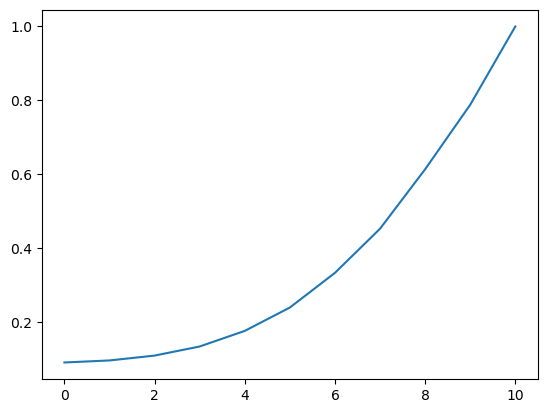

In [34]:
plt.plot(np.arange(contrast.shape[0]),contrast)

In [ ]:
folders=["locust_yellow2","locust_yellow1","locust_original","locust_green","cylinder_white","cylinder_black","black_background"]
Dataset_dir ="C:/Users/neuroPC/Documents/color_spectrum_matrexVR_20241104/"
mean_auc_list=[]
for this_folder in folders:
    thisDataset=Dataset_dir+this_folder
    dir_list=list_up_files(thisDataset)
    sorted_data_list=sorted(dir_list, key = last_nchars)
    auc_list=[]
    wavelength_list=[]
    for this_dir in sorted_data_list:
        if "archive" in this_dir:
            print(f"skip archive folder for {this_dir}")
            continue
        else:
            print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
            auc, wavelength=load_color_spectrum(this_dir)
            auc_list.append(auc)
            wavelength_list.append(wavelength)
    auc_array=np.reshape(np.array(auc_list),(2,-1))
    #mean_auc_list.append(auc_array[1,:])
    mean_auc_list.append(np.mean(auc_array,axis=0))

In [103]:
auc_array_conditions=np.vstack(mean_auc_list)

In [ ]:
m_contrast=abs((auc_array_conditions[:-1,:]-auc_array_conditions[-1,:])/(auc_array_conditions[:-1,:]+auc_array_conditions[-1,:]))
w_contrast=(auc_array_conditions[:-1,:]-auc_array_conditions[-1,:])/(auc_array_conditions[-1,:])

In [105]:
COL = MplColorHelper(colormap_name, 0, m_contrast.shape[0]-1)
sm = cm.ScalarMappable(cmap=colormap_name)
graph_colour_code=["r","b","y","g","c","k","m"]

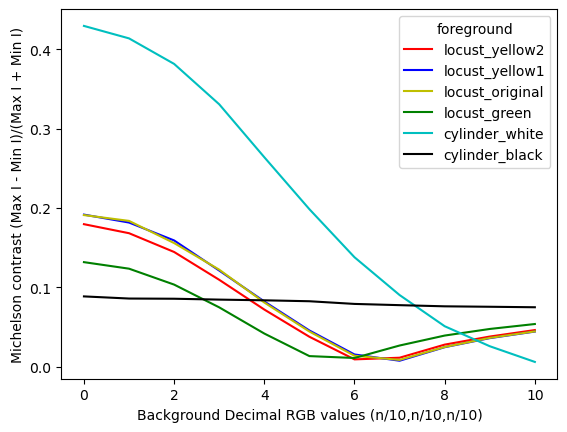

In [ ]:
for i in range(m_contrast.shape[0]):
    plt.plot(m_contrast[i,:],color=graph_colour_code[i],label=folders[i])
plt.legend(title='foreground category')
plt.xlabel ('Background Decimal RGB values (n/10,n/10,n/10)')
plt.ylabel ('Michelson contrast (Max I - Min I)/(Max I + Min I)')
plt.show()